In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [77]:
df = pd.read_csv('../data/captions.txt')

## Dataset Format


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [79]:
df.shape

(40455, 2)

In [80]:
df.describe()

,image,caption
count,40455,40455
unique,8091,40201
top,997722733_0cb5439472.jpg,Two dogs playing in the snow .
freq,5,7


## Treating nulls and duplicates

In [81]:
df.dropna(inplace=True)

In [82]:
df.drop_duplicates(inplace=True)

## Captioning cleaning

In [83]:
def clean_caption(text):
    # Remover pontuação e aspas
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = " ".join(text.translate(table).split()).lower()
    # Remover palavras com números e espaços extras
    words = [word for word in text.split() if word.isalpha()]
    return " ".join(words)

In [84]:
# 2. Aplicar a limpeza
df['caption_clean'] = df['caption'].apply(clean_caption)

# 3. Juntar Legendas e Imagens (Criar o caminho completo)
# Verifique se sua pasta se chama 'data' ou 'flickr8k_dataset'
image_path = "../data/Images/"
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_path, x))

# 4. Limpar Dados (Remover duplicatas e Nulos conforme solicitado)
df.dropna(subset=['caption_clean'], inplace=True)
df.drop_duplicates(inplace=True)

print("Estrutura atualizada com sucesso!")
print(df[['image', 'caption_clean', 'image_path']].head())

Estrutura atualizada com sucesso!
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                       caption_clean  \
0  a child in a pink dress is climbing up a set o...   
1                a girl going into a wooden building   
2     a little girl climbing into a wooden playhouse   
3  a little girl climbing the stairs to her playh...   
4  a little girl in a pink dress going into a woo...   

                                 image_path  
0  ../data/Images/1000268201_693b08cb0e.jpg  
1  ../data/Images/1000268201_693b08cb0e.jpg  
2  ../data/Images/1000268201_693b08cb0e.jpg  
3  ../data/Images/1000268201_693b08cb0e.jpg  
4  ../data/Images/1000268201_693b08cb0e.jpg  


## Stats


In [85]:
df.columns

Index(['image', 'caption', 'caption_clean', 'image_path'], dtype='object')

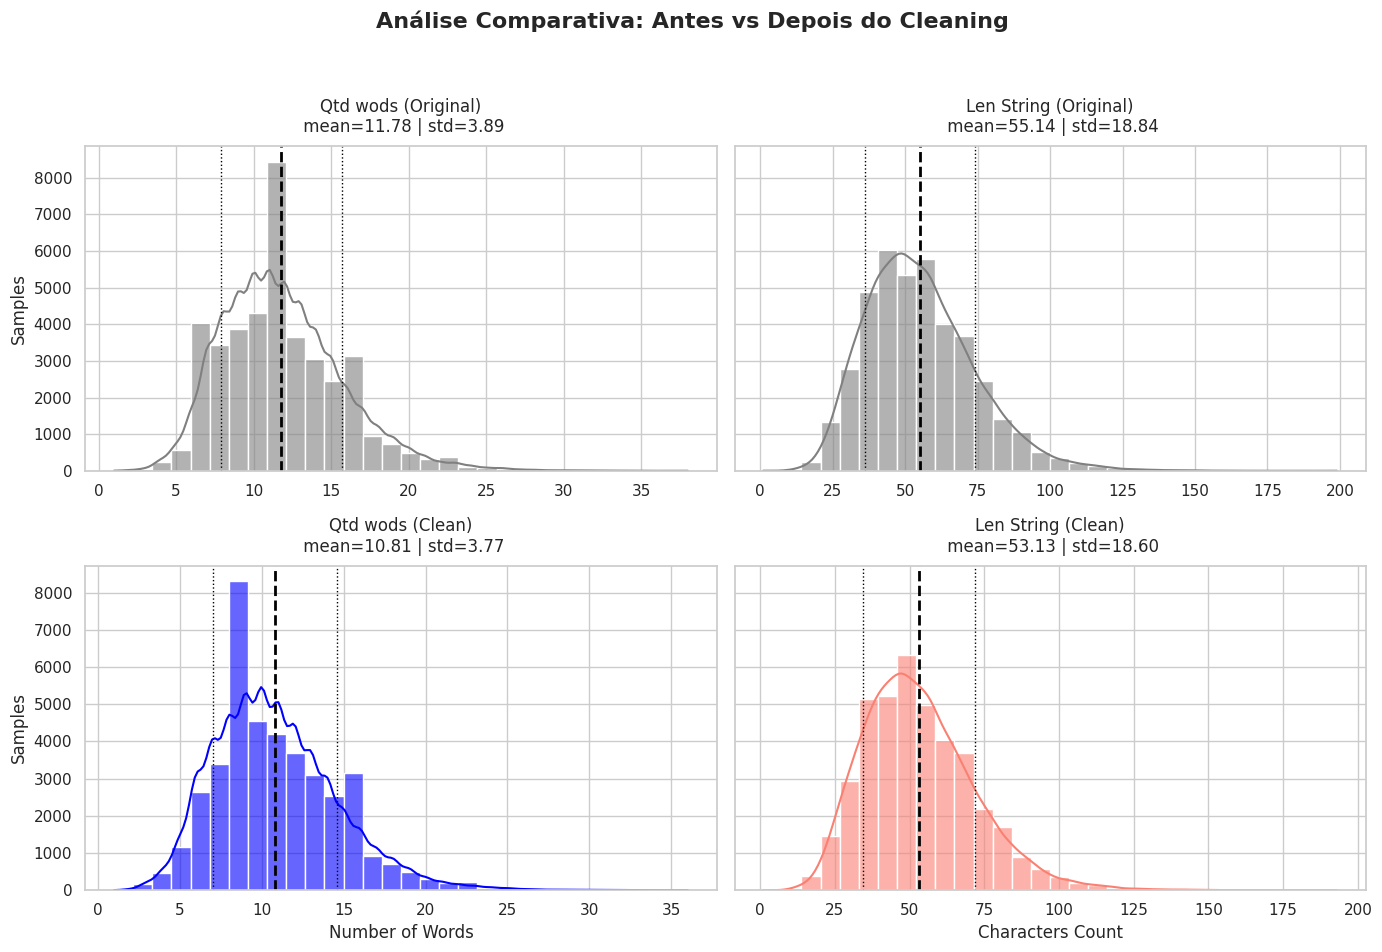

In [86]:

def plot_stat_hist(data, ax, title, color):

    mu, sigma = data.mean(), data.std()

    sns.histplot(data, bins=30, ax=ax, kde=True, color=color, alpha=0.6)

    # Stats lines
    ax.axvline(mu, color='black', linestyle='--', lw=2)
    ax.axvline(mu + sigma, color='black', linestyle=':', lw=1)
    ax.axvline(mu - sigma, color='black', linestyle=':', lw=1)

    # Values
    ax.set_title(f"{title}\n mean={mu:.2f} | std={sigma:.2f}", fontsize=12, pad=10)
    ax.set_xlabel("")

# --- Preparing the data ---
# Df to plot
df_stats = {
    "words_old": df['caption'].str.split().str.len(),
    "words_new": df['caption_clean'].str.split().str.len(),
    "len_old": df['caption'].str.len(),
    "len_new": df['caption_clean'].str.len()
}

# grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')
fig.suptitle("Análise Comparativa: Antes vs Depois do Cleaning", fontsize=16, fontweight='bold')

# original
plot_stat_hist(df_stats["words_old"], axes[0, 0], "Qtd wods (Original)", "gray")
plot_stat_hist(df_stats["len_old"], axes[0, 1], "Len String (Original)", "gray")

# clean
plot_stat_hist(df_stats["words_new"], axes[1, 0], "Qtd wods (Clean)", "blue")
plot_stat_hist(df_stats["len_new"], axes[1, 1], "Len String (Clean)", "salmon")


axes[1, 0].set_xlabel("Number of Words")
axes[1, 1].set_xlabel("Characters Count")
axes[0, 0].set_ylabel("Samples")
axes[1, 0].set_ylabel("Samples")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Cleaning size of the captions

In [87]:
words_min = df_stats['words_new'].min()
words_max = df_stats['words_new'].max()

print(f"Number of words : [{words_min},{words_max}]")

threshold_size_caption = words_min #Captions with size 1 are "A", noise

df[number_words_df == threshold_size_caption].head()


Number of words : [1,36]


,image,caption,caption_clean,image_path
9305,2428275562_4bde2bc5ea.jpg,A,a,../data/Images/2428275562_4bde2bc5ea.jpg
33360,3640443200_b8066f37f6.jpg,a,a,../data/Images/3640443200_b8066f37f6.jpg


In [88]:
#Clean both captions
df = df[number_words_df > threshold_size_caption]

## Most frequent words

/tmp/ipython-input-265341919.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.values, y=top_20.index, palette='viridis')


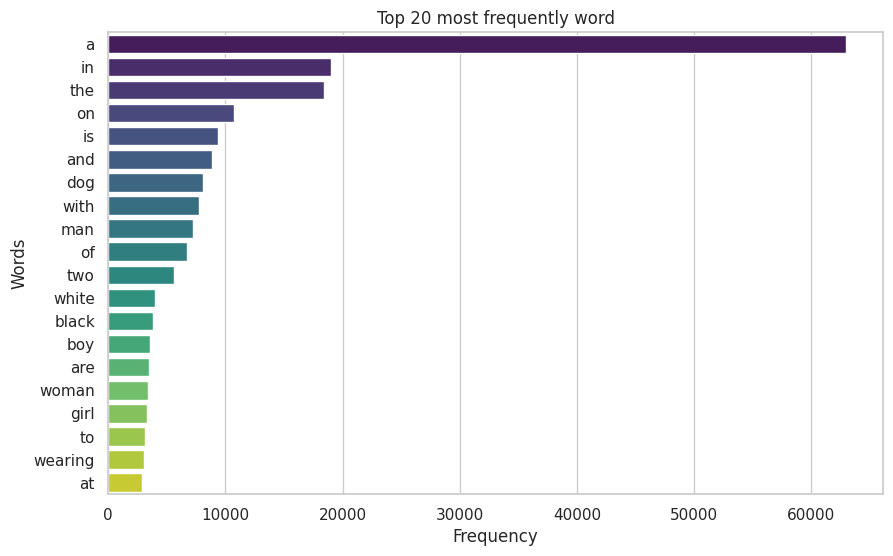

In [89]:
words_df = df['caption_clean'].str.split()
# Catch  the 20 most unused
words_and_instances_df = words_df.explode().value_counts()
top_20 = words_and_instances_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_20.values, y=top_20.index, palette='viridis')

plt.title('Top 20 most frequently word')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [90]:
number_of_single_instances_words = len(words_and_instances_df[words_and_instances_df == 1])
number_of_double_instances_words = len(words_and_instances_df[words_and_instances_df == 2])
number_of_triple_instances_words = len(words_and_instances_df[words_and_instances_df == 3])

print(f"TOTAL NUMBER OF WORDS: {len(words_and_instances_df)}"
      f"\nWORDS WITH A SINGLE INSTANCE: {number_of_single_instances_words}",
      f"\nWORDS WITH DOUBLE INSTANCES: {number_of_double_instances_words}",
      f"\nWORDS WITH TRIPLE INSTANCES: {number_of_triple_instances_words}")


TOTAL NUMBER OF WORDS: 8438
WORDS WITH A SINGLE INSTANCE: 3309 
WORDS WITH DOUBLE INSTANCES: 1064 
WORDS WITH TRIPLE INSTANCES: 656


## Test


FileNotFoundError: [Errno 2] No such file or directory: '../data/Images/2838619742_eed855d8a8.jpg'

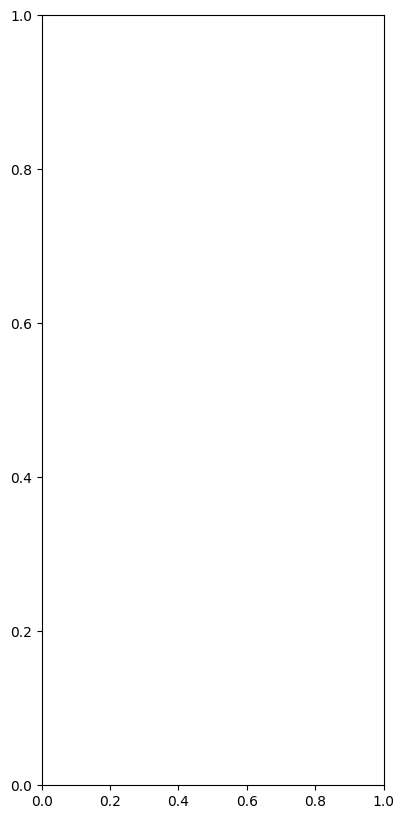

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Selecionar 3 amostras aleatórias
samples = df.sample(3)

plt.figure(figsize=(15, 10))

for i, (index, row) in enumerate(samples.iterrows()):
    plt.subplot(1, 3, i+1)

    # Abrir a imagem usando o caminho que criamos
    img = Image.open(row['image_path'])
    plt.imshow(img)

    # Adicionar a legenda limpa (com quebra de linha para não cortar)
    title = row['caption_clean']
    wrapped_title = "\n".join([title[i:i+30] for i in range(0, len(title), 30)])
    plt.title(wrapped_title, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Salvar o dataframe processado para uso futuro
# index=False evita que o pandas crie uma coluna extra de números desnecessária
df.to_csv('../data/flickr8k_cleaned_data.csv', index=False)

print("Arquivo 'flickr8k_cleaned_data.csv' salvo com sucesso!")

Arquivo 'flickr8k_cleaned_data.csv' salvo com sucesso!


In [ ]:
# Teste rápido: ler o que acabamos de salvar
check_df = pd.read_csv('../data/flickr8k_cleaned_data.csv')
print("O arquivo salvo tem", len(check_df), "linhas.")
check_df.head(2)

O arquivo salvo tem 40445 linhas.


,image,caption,caption_clean,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a child in a pink dress is climbing up a set o...,data/Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a girl going into a wooden building,data/Images/1000268201_693b08cb0e.jpg


## Saving


In [91]:
# Salvar o dataframe processado para uso futuro
# index=False evita que o pandas crie uma coluna extra de números desnecessária
df.to_csv('../data/flickr8k_cleaned_data.csv', index=False)

print("Arquivo 'flickr8k_cleaned_data.csv' salvo com sucesso!")

Arquivo 'flickr8k_cleaned_data.csv' salvo com sucesso!


In [92]:
check_df = pd.read_csv('../data/flickr8k_cleaned_data.csv')
print("O arquivo salvo tem", len(check_df), "linhas.")
check_df.head(2)

O arquivo salvo tem 40443 linhas.


,image,caption,caption_clean,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a child in a pink dress is climbing up a set o...,../data/Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a girl going into a wooden building,../data/Images/1000268201_693b08cb0e.jpg
